## Lending Club Loan Data Analysis and Prediction - Part 2

### Project Outlines:

#### 1. Define goal 

    a.Identify most important attributes separating bad loans and good loans 
    b.Build Xgboost model to make prediction
    
#### 2. EDA

    a.Data first impression
      -available predicting variables
      -data distribution
      -missing values
    b.Split dataset in to training and test set
    c.correlation analysis and remove multicollinearity
    d.Data Visualization to explore relationship between target and predicting variables
    
#### 3. Data Cleansing and Feature Engineering

    a. Handling missing values
    b. Transform any characteristics or categorical variables into numeric
    c. Create new features from existing features

#### 4. Prepare dataset for modeling:
    - Standard scale
    - Handling Dataset imbalance issues (upsampling)
        
#### 5. Model Training and Evaluation
    1). Logistic regression with L1 regularization model
    2). Random Forest model 
    3). Xgboost model
        -hyperparameters Tuning
    
#### 6. Feature Selections Consideration
    - Remove variables according to correlation analysis
    - Logistic regression with L1 regularization (coeffecients not zero)
    - Random Forest model built-in feature importance

#### 7. Assess any additional feature engineering or feature selection opportunity based on model results

#### 8. Choose the best model and evaluate prediction on test dataset

#### 9. Areas of improvements

 
### Part-2
This project is split into 3 parts, and this notebook is for the 2nd part - data cleaning and feature engineering.


### Data Source
[Link to Data](https://www.kaggle.com/wordsforthewise/lending-club)

In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
matplotlib.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


This notebook continues from part 1 of Lending_club_loan_default_prediction: EDA&Correlation.

### 3. Data cleansing and Feature Engineering

In [3]:
# load train, test set created from part1
xtrain = pd.read_csv("xtrain.csv")

In [7]:
xtest = pd.read_csv("xtest.csv")


In [8]:
# Convert issue date to year and month separate variables
xtrain["issue_year"]= pd.to_datetime(xtrain.issue_d).dt.year
xtrain["issue_month"]= pd.to_datetime(xtrain.issue_d).dt.month
xtrain.drop("issue_d", axis=1,inplace = True)

In [9]:
# Check if any columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]

member_id                              1808534
desc                                   1707518
mths_since_last_delinq                  927012
mths_since_last_record                 1521135
mths_since_last_major_derog            1344285
annual_inc_joint                       1712034
dti_joint                              1712038
verification_status_joint              1715995
mths_since_recent_bc_dlq               1392912
mths_since_recent_revol_delinq         1215903
revol_bal_joint                        1722207
sec_app_fico_range_low                 1722207
sec_app_fico_range_high                1722207
sec_app_earliest_cr_line               1722207
sec_app_inq_last_6mths                 1722207
sec_app_mort_acc                       1722207
sec_app_open_acc                       1722207
sec_app_revol_util                     1723670
sec_app_open_act_il                    1722207
sec_app_num_rev_accts                  1722207
sec_app_chargeoff_within_12_mths       1722207
sec_app_colle

In [10]:
# Check the exact percentage of missing values for the columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]/len(xtrain)

member_id                              1.000000
desc                                   0.944145
mths_since_last_delinq                 0.512576
mths_since_last_record                 0.841087
mths_since_last_major_derog            0.743301
annual_inc_joint                       0.946642
dti_joint                              0.946644
verification_status_joint              0.948832
mths_since_recent_bc_dlq               0.770188
mths_since_recent_revol_delinq         0.672314
revol_bal_joint                        0.952267
sec_app_fico_range_low                 0.952267
sec_app_fico_range_high                0.952267
sec_app_earliest_cr_line               0.952267
sec_app_inq_last_6mths                 0.952267
sec_app_mort_acc                       0.952267
sec_app_open_acc                       0.952267
sec_app_revol_util                     0.953076
sec_app_open_act_il                    0.952267
sec_app_num_rev_accts                  0.952267
sec_app_chargeoff_within_12_mths       0

In [11]:
# remove member_id column as it's just a system generated number
xtrain.drop("member_id",axis=1, inplace= True)

In [12]:
# Create dummy variables for loans with desc and without
xtrain["desc_y"]= np.where(xtrain.desc.notnull(), 1, 0)
xtrain["desc_n"]= np.where(xtrain.desc.isnull(), 1, 0)
xtrain.drop("desc", axis=1, inplace=True)

In [13]:
# Noted there are 84% loans with missing values in mths_since_last_record
print(str(round(xtrain.mths_since_last_record.isnull().sum()/len(xtrain),4))+ " of total loans have no values of mths_since_last_record")

#Create dummy variables to indicate a loan with mths_since_last_record and without
xtrain["pub_record_y"]= np.where(xtrain.mths_since_last_record.notnull(), 1, 0)
xtrain["pub_record_n"]= np.where(xtrain.mths_since_last_record.isnull(), 1, 0)


0.8411 of total loans have no values of mths_since_last_record


In [14]:
# percentage of individual and joint application
xtrain.application_type.value_counts()/len(xtrain)

Individual    0.946642
Joint App     0.053358
Name: application_type, dtype: float64

The following columns measures the combined values of joint borrowers: <br>
- annual_inc_joint                       
- dti_joint                              
- verification_status_joint  
- revol_bal_joint                        
                   


Since the missing values in the 4 joint-related variables are for those 94.7% individual applicants, impute to fill missing value are not reasonable. Instead, I combine the values of these 4 joint-related variables into the their respective variables measuring the individual applicants, and the remove these 4 joint-related variables. Therefore we won't lose any information about the joint application and eliminate any data duplicate problem. 

In [15]:
# Obtain the combined values of joint borrowers for those joint loan applications
joint_ann_inc = xtrain.loc[xtrain.application_type=="Joint App","annual_inc_joint"].values
join_dti = xtrain.loc[xtrain.application_type=="Joint App","dti_joint"].values
joint_ver = xtrain.loc[xtrain.application_type=="Joint App","verification_status_joint"].values
joint_revo_bal = xtrain.loc[xtrain.application_type=="Joint App","revol_bal_joint"].values

In [16]:
# Combine joint variables into the their respective variables measuring individual borrowers
xtrain.loc[xtrain.application_type=="Joint App","annual_inc"]= joint_ann_inc
xtrain.loc[xtrain.application_type=="Joint App","dti"]= join_dti 
xtrain.loc[xtrain.application_type=="Joint App","verification_status"]= joint_ver
xtrain.loc[xtrain.application_type=="Joint App","revol_bal"]= joint_revo_bal

The following variables are related to loans that has secondary applicant: 

- sec_app_fico_range_low                 
- sec_app_fico_range_high                
- sec_app_earliest_cr_line               
- sec_app_inq_last_6mths                 
- sec_app_mort_acc                       
- sec_app_open_acc                       
- sec_app_revol_util                     
- sec_app_open_act_il                    
- sec_app_num_rev_accts                  
- sec_app_chargeoff_within_12_mths       
- sec_app_collections_12_mths_ex_med     
- sec_app_mths_since_last_major_derog

Since there are only 4.78% of loans have secondary applicant, it's not appropriate to fill the missing values for loans without secondary applicants. Noted there are high correlations between three secondary-related variables(including sec_app_fico_range_low,sec_app_fico_range_high, sec_app_inq_last_6mth) and the target variable. I am generating dummy variables to indicate the number of inquires last 6mth of secondary applicant and removed all the other secondary-applicant related columns. For the FICO-score variables, I am using the following ratings to convert numeric FICO score to categorical variable. <br>

 \>= 800  Exceptional <br>
 740-799  Very Good <br>
 670-739  Good <br>
 580-669  Fair <br>
 < 580	  Very Poor <br>

In [17]:
print(str(round(xtrain.sec_app_earliest_cr_line.notnull().sum()/len(xtrain),4))+" of loans have secondary applicant")

0.0477 of loans have secondary applicant


In [18]:
# Convert sec_app_fico_range_low from a numeric variable to a categorical variable
xtrain["sec_app_fico_no"] = np.where(xtrain.sec_app_fico_range_low.isnull(),1,0)
xtrain["sec_app_fico_range_low_exceptional"] = np.where(xtrain.sec_app_fico_range_low >= 800,1,0)
xtrain["sec_app_fico_range_low_verygood"] = np.where((xtrain.sec_app_fico_range_low >=740) & (xtrain.sec_app_fico_range_low <= 799), 1,0)
xtrain["sec_app_fico_range_low_good"] = np.where((xtrain.sec_app_fico_range_low >=670) & (xtrain.sec_app_fico_range_low <= 739), 1,0)
xtrain["sec_app_fico_range_low_fair"] = np.where((xtrain.sec_app_fico_range_low >=580) & (xtrain.sec_app_fico_range_low <= 669), 1,0)
xtrain["sec_app_fico_range_low_verypoor"] = np.where(xtrain.sec_app_fico_range_low < 580,1,0)


In [19]:
#Convert sec_app_fico_range_high from a numeric variable to a categorical variable
xtrain["sec_app_fico_range_high_exceptional"] = np.where(xtrain.sec_app_fico_range_high >= 800,1,0)
xtrain["sec_app_fico_range_high_verygood"] = np.where((xtrain.sec_app_fico_range_high >=740) & (xtrain.sec_app_fico_range_high <= 799), 1,0)
xtrain["sec_app_fico_range_high_good"] = np.where((xtrain.sec_app_fico_range_high >=670) & (xtrain.sec_app_fico_range_high <= 739), 1,0)
xtrain["sec_app_fico_range_high_fair"] = np.where((xtrain.sec_app_fico_range_high >=580) & (xtrain.sec_app_fico_range_high <= 669), 1,0)
xtrain["sec_app_fico_range_high_verypoor"] = np.where(xtrain.sec_app_fico_range_high < 580,1,0)


0.0    52250
1.0    21450
2.0     7751
3.0     2941
4.0     1205
5.0      519
6.0      211
Name: sec_app_inq_last_6mths, dtype: int64

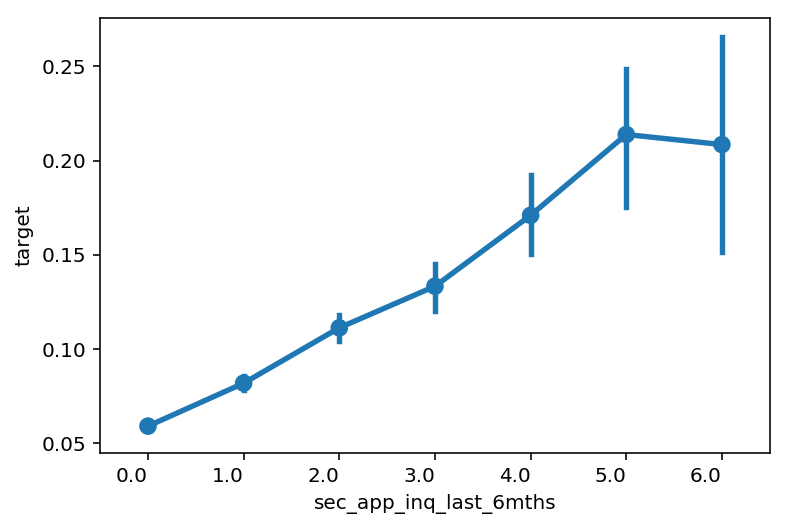

In [20]:
# Check the loan status between different sec_app_inq_last_6mths
plt.figure(figsize=(6,4))
chart = sns.pointplot(x = "sec_app_inq_last_6mths", y = 'target', data = xtrain)
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right')
xtrain.sec_app_inq_last_6mths.value_counts()

In [21]:
# Create dummies for loan's sec_app_inq_last_6mths
xtrain["no_sec_app"] = np.where(xtrain.sec_app_inq_last_6mths.isnull(),1,0)
sec_app_inq= pd.get_dummies(xtrain.sec_app_inq_last_6mths, prefix="sec_app_inq_")
xtrain = pd.concat([xtrain, sec_app_inq], axis=1)


#### Delinquent related features

In [22]:
deli_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog",
            "mths_since_recent_inq"]


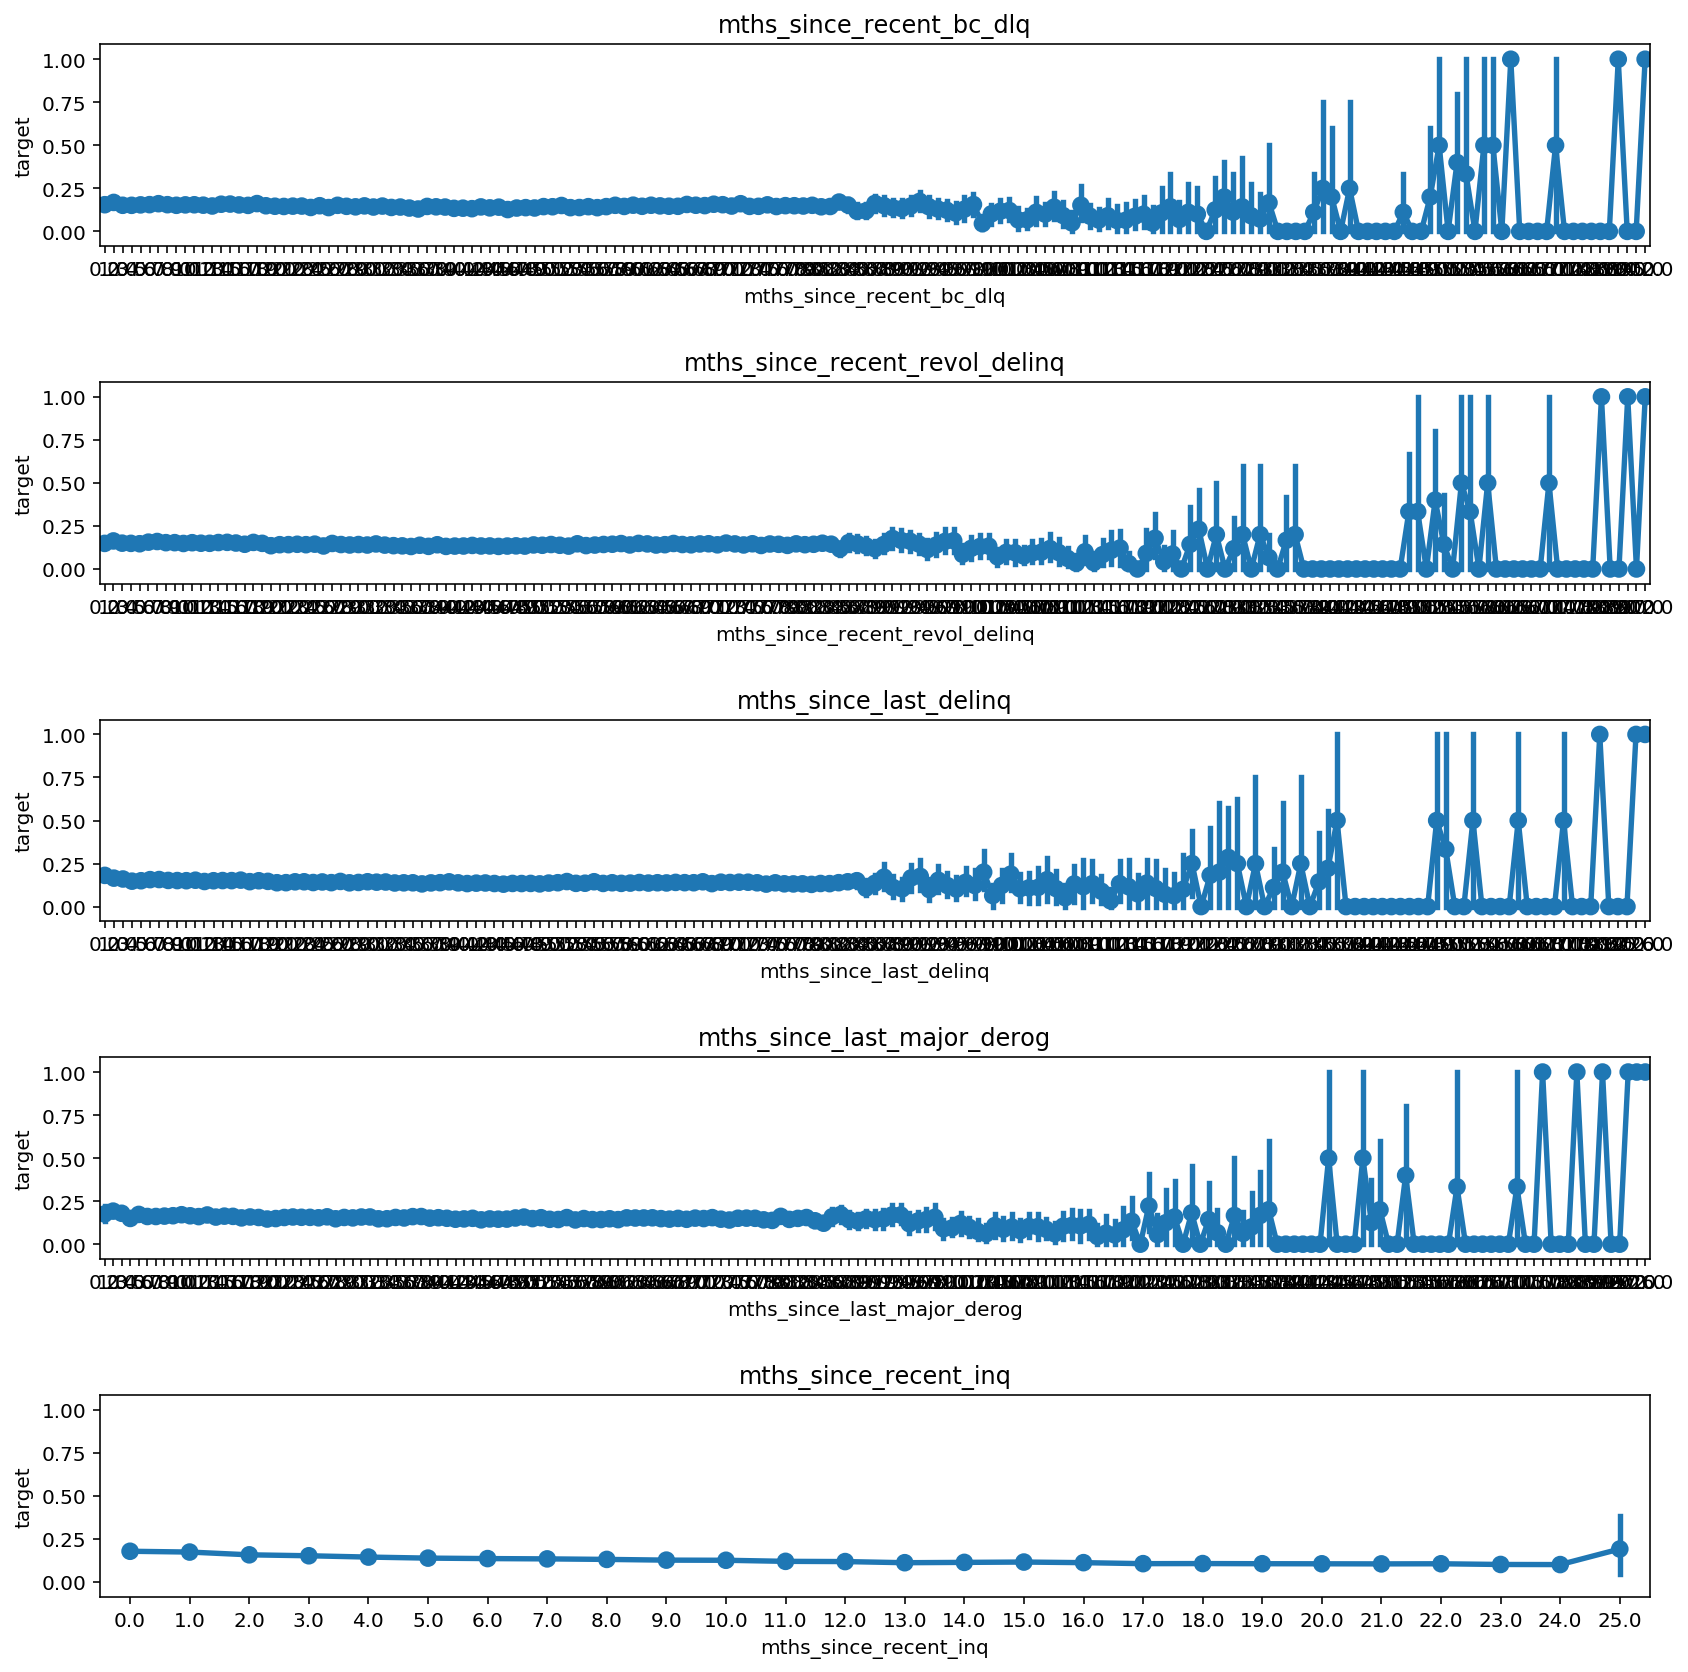

In [23]:
# Check distribution 
f, axes = plt.subplots(5, 1, figsize=(12, 12),  sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(5):
    chart = sns.pointplot(x = deli_cols[i], y = 'target', data = xtrain, ax = axes[i])
    axes[i].set_title(deli_cols[i])
    
f.tight_layout(pad=2.0)
plt.show()
    


Based on the plots above, we can see that the longer time since last delinquent, the less likely a loan is in trouble status. <br>
A consistent pattern is presented in all deliquent related features: as the number of months since last deliquency gets larger, the likelihood of a loan turning to default decrease. This is reasonable in business sense as we can assume that borrowers who have been consistently paying their loan repayment for a period of time are more likely to continue paying, which indicating good loans. 

In [24]:
def check_diff(col):
    print(col)
    print(round( xtrain.loc[xtrain[col].isnull(),"target"].mean(),4))
    print(round( xtrain.loc[xtrain[col].notnull(),"target"].mean(),4))

In [25]:
del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog"]

for i in del_cols:
    check_diff(i)

mths_since_recent_bc_dlq
0.1308
0.1459
mths_since_recent_revol_delinq
0.1303
0.1425
mths_since_last_delinq
0.1269
0.1421
mths_since_last_major_derog
0.1284
0.1515


In [26]:
# Use Weighted Average method for delinquent related missing values

def fill_delinq(col):
    # Summary ratio of bad loans by variable of interest
    df = xtrain.loc[:,[col,"target"]].groupby([col]).agg(['mean', 'count'])
    
    # The ratio of bad loans in the missing value group
    target_mean = xtrain.loc[xtrain[col].isnull(),"target"].mean()
    target_std  = xtrain.loc[xtrain[col].isnull(),"target"].std()
    
    # Use the ratio of bad loans of the missing value group to find the existing data range that has similar bad loan ratio within +/-a range
    df= df.loc[(df['target']['mean'].values >= (target_mean - 0.05*target_std)) & (df['target']['mean'].values <= (target_mean + 0.01* target_std)),:]
    
    df["weighted_avg"] = df['target']['count']/sum(df['target']['count'])

    # Calculate the weighted average mths_since_last_delinq of loans
    w_avg =0
    for i in range(len(df)):
        w_avg += df.index[i] * df.weighted_avg.tolist()[i]
       
    
    return w_avg
    

In [27]:
# Fill NaN for delinquence related features.
# Based on the point plot of delinquent-related features vs target, the ratio of bad loans decreases as the number of months since last/recent delinquent increases.

del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog"]

for i in del_cols:
    w_avg =fill_delinq(i)
    xtrain.loc[xtrain[i].isnull(), i ] = w_avg

In [28]:
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]/len(xtrain)

mths_since_last_record                 0.841087
annual_inc_joint                       0.946642
dti_joint                              0.946644
verification_status_joint              0.948832
revol_bal_joint                        0.952267
sec_app_fico_range_low                 0.952267
sec_app_fico_range_high                0.952267
sec_app_earliest_cr_line               0.952267
sec_app_inq_last_6mths                 0.952267
sec_app_mort_acc                       0.952267
sec_app_open_acc                       0.952267
sec_app_revol_util                     0.953076
sec_app_open_act_il                    0.952267
sec_app_num_rev_accts                  0.952267
sec_app_chargeoff_within_12_mths       0.952267
sec_app_collections_12_mths_ex_med     0.952267
sec_app_mths_since_last_major_derog    0.984197
dtype: float64

In [29]:
# Now we are ready to drop the features with over 80% missing values
xtrain.drop(["mths_since_last_record" ,
            "annual_inc_joint" ,                      
            "dti_joint",                              
            "verification_status_joint"  ,            
            "revol_bal_joint"   ,                     
            "sec_app_fico_range_low",                
            "sec_app_fico_range_high",             
            "sec_app_earliest_cr_line",        
            "sec_app_inq_last_6mths"  ,               
            "sec_app_mort_acc" ,                     
            "sec_app_open_acc"  ,                     
            "sec_app_revol_util"  ,                
            "sec_app_open_act_il" ,                  
            "sec_app_num_rev_accts" ,               
            "sec_app_chargeoff_within_12_mths" ,      
            "sec_app_collections_12_mths_ex_med" ,    
            "sec_app_mths_since_last_major_derog" ],
          axis=1, inplace=True)

In [30]:
# Double Check if any columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]

Series([], dtype: int64)

#### Continue handling missing values


In [31]:
# # Check all numeric columns
# numcols = data.select_dtypes(include=np.number).columns.tolist()

In [32]:
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

emp_title                     133526
emp_length                    117451
annual_inc                         3
verification_status             3961
title                          18691
                               ...  
tax_liens                         83
tot_hi_cred_lim                56468
total_bal_ex_mort              40220
total_bc_limit                 40220
total_il_high_credit_limit     56468
Length: 68, dtype: int64

Employment title

In [33]:
#Assign missing values in emp_title as undisclosed 
xtrain.loc[xtrain.emp_title.isnull(), "emp_title"] ="Undisclosed"

In [34]:
# The group similar employment title together, and create dummy variables for the top 5 employee title categories, and the rest would be Other
mgt_title =['Manager','manager','Supervisor','supervisor','President','president',
            'Director','Leader','director','leader','Administrator','administrator','VP']
nurse_title = ['Registered Nurse','nurse','Nurse','RN']
teacher_title = ['teacher','Teacher']
owner_title = ['Owner','owner']
driver_title = ['Driver','driver']
titles = dict({"mgt_title":mgt_title,"nurse_title":nurse_title,"teacher_title": teacher_title,
               "owner_title": owner_title,"driver_title":driver_title})


In [35]:
# Create a dictionary for these employment title variables
title_dict = {}
for key,value in titles.items():
    title_dict[key]=[int(sum([1 if j in value else 0 for j in i.split()]) > 0) for i in xtrain['emp_title'].values ]
    


In [36]:
# Concat the employee title dummy variables 
title_df = pd.DataFrame(title_dict)
title_df.reset_index(drop=True, inplace=True)
xtrain.reset_index(drop=True, inplace=True)
xtrain = pd.concat([xtrain, title_df], axis=1)

In [37]:
# Add dummy variable of employment title to the dataset
xtrain['emp_undisc'] = np.where(xtrain.emp_title=='Undisclosed',1,0)

In [38]:
# Add dummy variable of Other employment title to the dataset
xtrain['title_other'] = np.where((xtrain.emp_undisc + xtrain.mgt_title + xtrain.nurse_title + xtrain.teacher_title + xtrain.owner_title+ xtrain.driver_title) == 0,1,0)

In [39]:
xtrain.drop("emp_title", axis=1, inplace=True)

Employment length

In [40]:
# As the majority of missing values in emp_length are associated with undisclosed emp_title. I will fill NA values in emp_length with random samples from the undisclosed group
emp_len_isnull = xtrain.emp_length.isnull()
emp_len_samples = xtrain.loc[(xtrain.emp_undisc==1) & (xtrain.emp_length.notnull()), 'emp_length'].sample(emp_len_isnull.sum(),replace= True).values
xtrain.loc[emp_len_isnull,"emp_length"] = emp_len_samples

In [41]:
# Extract the number of years from emp_length column, convert it to string and fill NaN with the mean.
xtrain['emp_length'] = xtrain['emp_length'].str.extract('(\d+)')
xtrain['emp_length'] = pd.to_numeric(xtrain["emp_length"])
# Assumptions: borrowers who has 10 years or more than 10 years of employment are similar in their debt repaymnet 

Loan grade and subgrade

In [42]:
# Assgin a score to each loan grade by calculating the ratio of bad loans in each grade
dfgrade = xtrain.loc[:,["grade","target"]].groupby(["grade"]).mean()
dfgrade = round(dfgrade*100,0).to_dict()['target']
dfgrade

{'A': 4.0, 'B': 9.0, 'C': 15.0, 'D': 21.0, 'E': 29.0, 'F': 37.0, 'G': 41.0}

In [43]:
# Assgin a score to each loan subgrade by calculating the ratio of bad loans in each grade
dfsubgrade = xtrain.loc[:,["sub_grade","target"]].groupby(["sub_grade"]).mean()
dfsubgrade = round(dfsubgrade*100,0).to_dict()['target']


In [44]:
# Convert loan grade and loan subgrades to numerica value
xtrain['grade'] = xtrain['grade'].map(dfgrade)
xtrain['sub_grade'] = xtrain['sub_grade'].map(dfsubgrade)

Loan purpose

[Text(0, 0, 'credit_card'),
 Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'other'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'car'),
 Text(0, 0, 'house'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'wedding'),
 Text(0, 0, 'renewable_energy'),
 Text(0, 0, 'educational')]

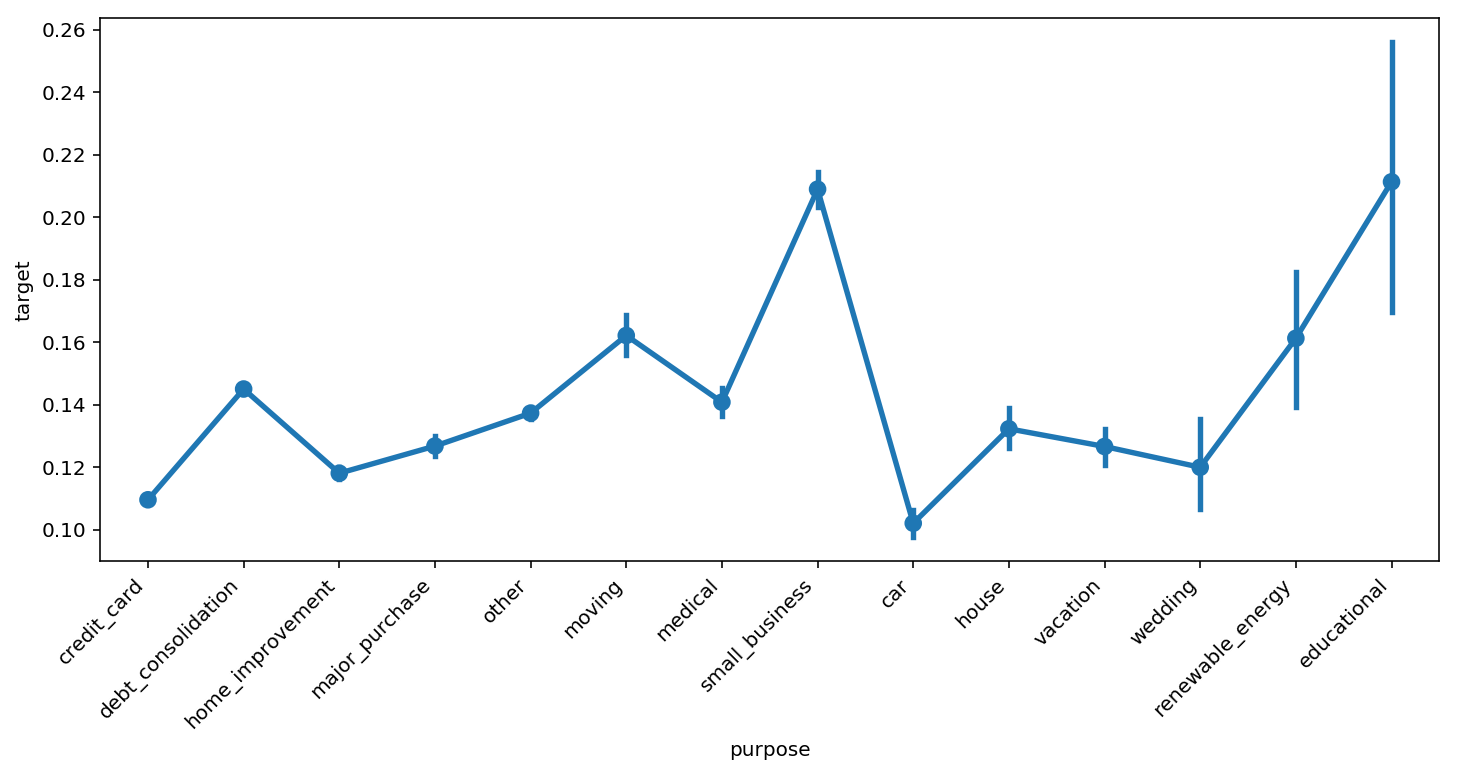

In [45]:
# Check the loan status between different loan purposes
plt.figure(figsize=(12, 5))
chart = sns.pointplot(x = "purpose", y = 'target', data = xtrain)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [46]:
# Inspect column title (the loan title provided by the borrower)
# Noted that column title provides the similar information as column purpose
xtrain[["purpose",'title']].head(10)

,purpose,title
0,credit_card,Credit card refinancing
1,debt_consolidation,100% PAYMENT RECORD
2,credit_card,Credit card refinancing
3,debt_consolidation,Debt consolidation
4,credit_card,Credit card refinancing
5,debt_consolidation,Debt consolidation
6,debt_consolidation,Debt consolidation
7,debt_consolidation,Debt consolidation
8,debt_consolidation,Debt consolidation
9,home_improvement,Home improvement


In [47]:
# Drop xolumn title as it provides similar information of loan purpose. 
xtrain.drop("title",axis=1, inplace=True)

In [48]:
# check missing values for the following columns before converting them to dummy variables
xtrain[["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
        ]].isnull().sum()

application_type          0
initial_list_status       0
term                      0
purpose                   0
home_ownership            0
verification_status    3961
disbursement_method       0
dtype: int64

In [49]:
xtrain.verification_status.value_counts()

Source Verified    709953
Not Verified       605612
Verified           489008
Name: verification_status, dtype: int64

In [50]:
xtrain.loc[xtrain.verification_status.isnull(),"verification_status"]='verified_unknown'

In [51]:
xtrain.verification_status.value_counts()

Source Verified     709953
Not Verified        605612
Verified            489008
verified_unknown      3961
Name: verification_status, dtype: int64

In [52]:
todummy = ["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
          ]
    
# Convert application_type to dummy variables
for i in todummy:
    dummy = pd.get_dummies(xtrain[i], prefix = i)
    xtrain = pd.concat([xtrain, dummy], axis=1)
    xtrain.drop(i, axis=1, inplace=True)


In [53]:
# combine home ownership other, none and any into one group:Other
xtrain.home_ownership_OTHER = xtrain.home_ownership_OTHER + xtrain.home_ownership_ANY + xtrain.home_ownership_NONE
 
xtrain.drop(["home_ownership_ANY","home_ownership_NONE"], axis=1, inplace=True)

Borrower's Address, state and zip code

In [54]:
address = ["addr_state","zip_code"]

In [55]:
# Calculate the percentage of bad loans of each state
for i in address:
    df= xtrain.loc[:,[i,"target"]].groupby([i]).mean()
    df  = round(df*100,2).to_dict()['target']
    xtrain[i] = xtrain[i].map(df)

In [56]:
# Noted there is one missing value in zip_code, fillna with mode
xtrain.loc[xtrain.zip_code.isnull(), "zip_code"] = xtrain['zip_code'].mode()[0]

In [57]:
col_list2 = ['dti', # borrower’s total monthly debt payments on the total debt obligations
    'revol_util', # Borrowers' revol_utilization rate
     'annual_inc', # annual income
    'tot_coll_amt', # Total collection amounts ever owed
    'revol_bal', # Total credit revolving balance
    'delinq_2yrs'#Number of 30+days past-due incidences of delinquency for the past 2 years
            ]

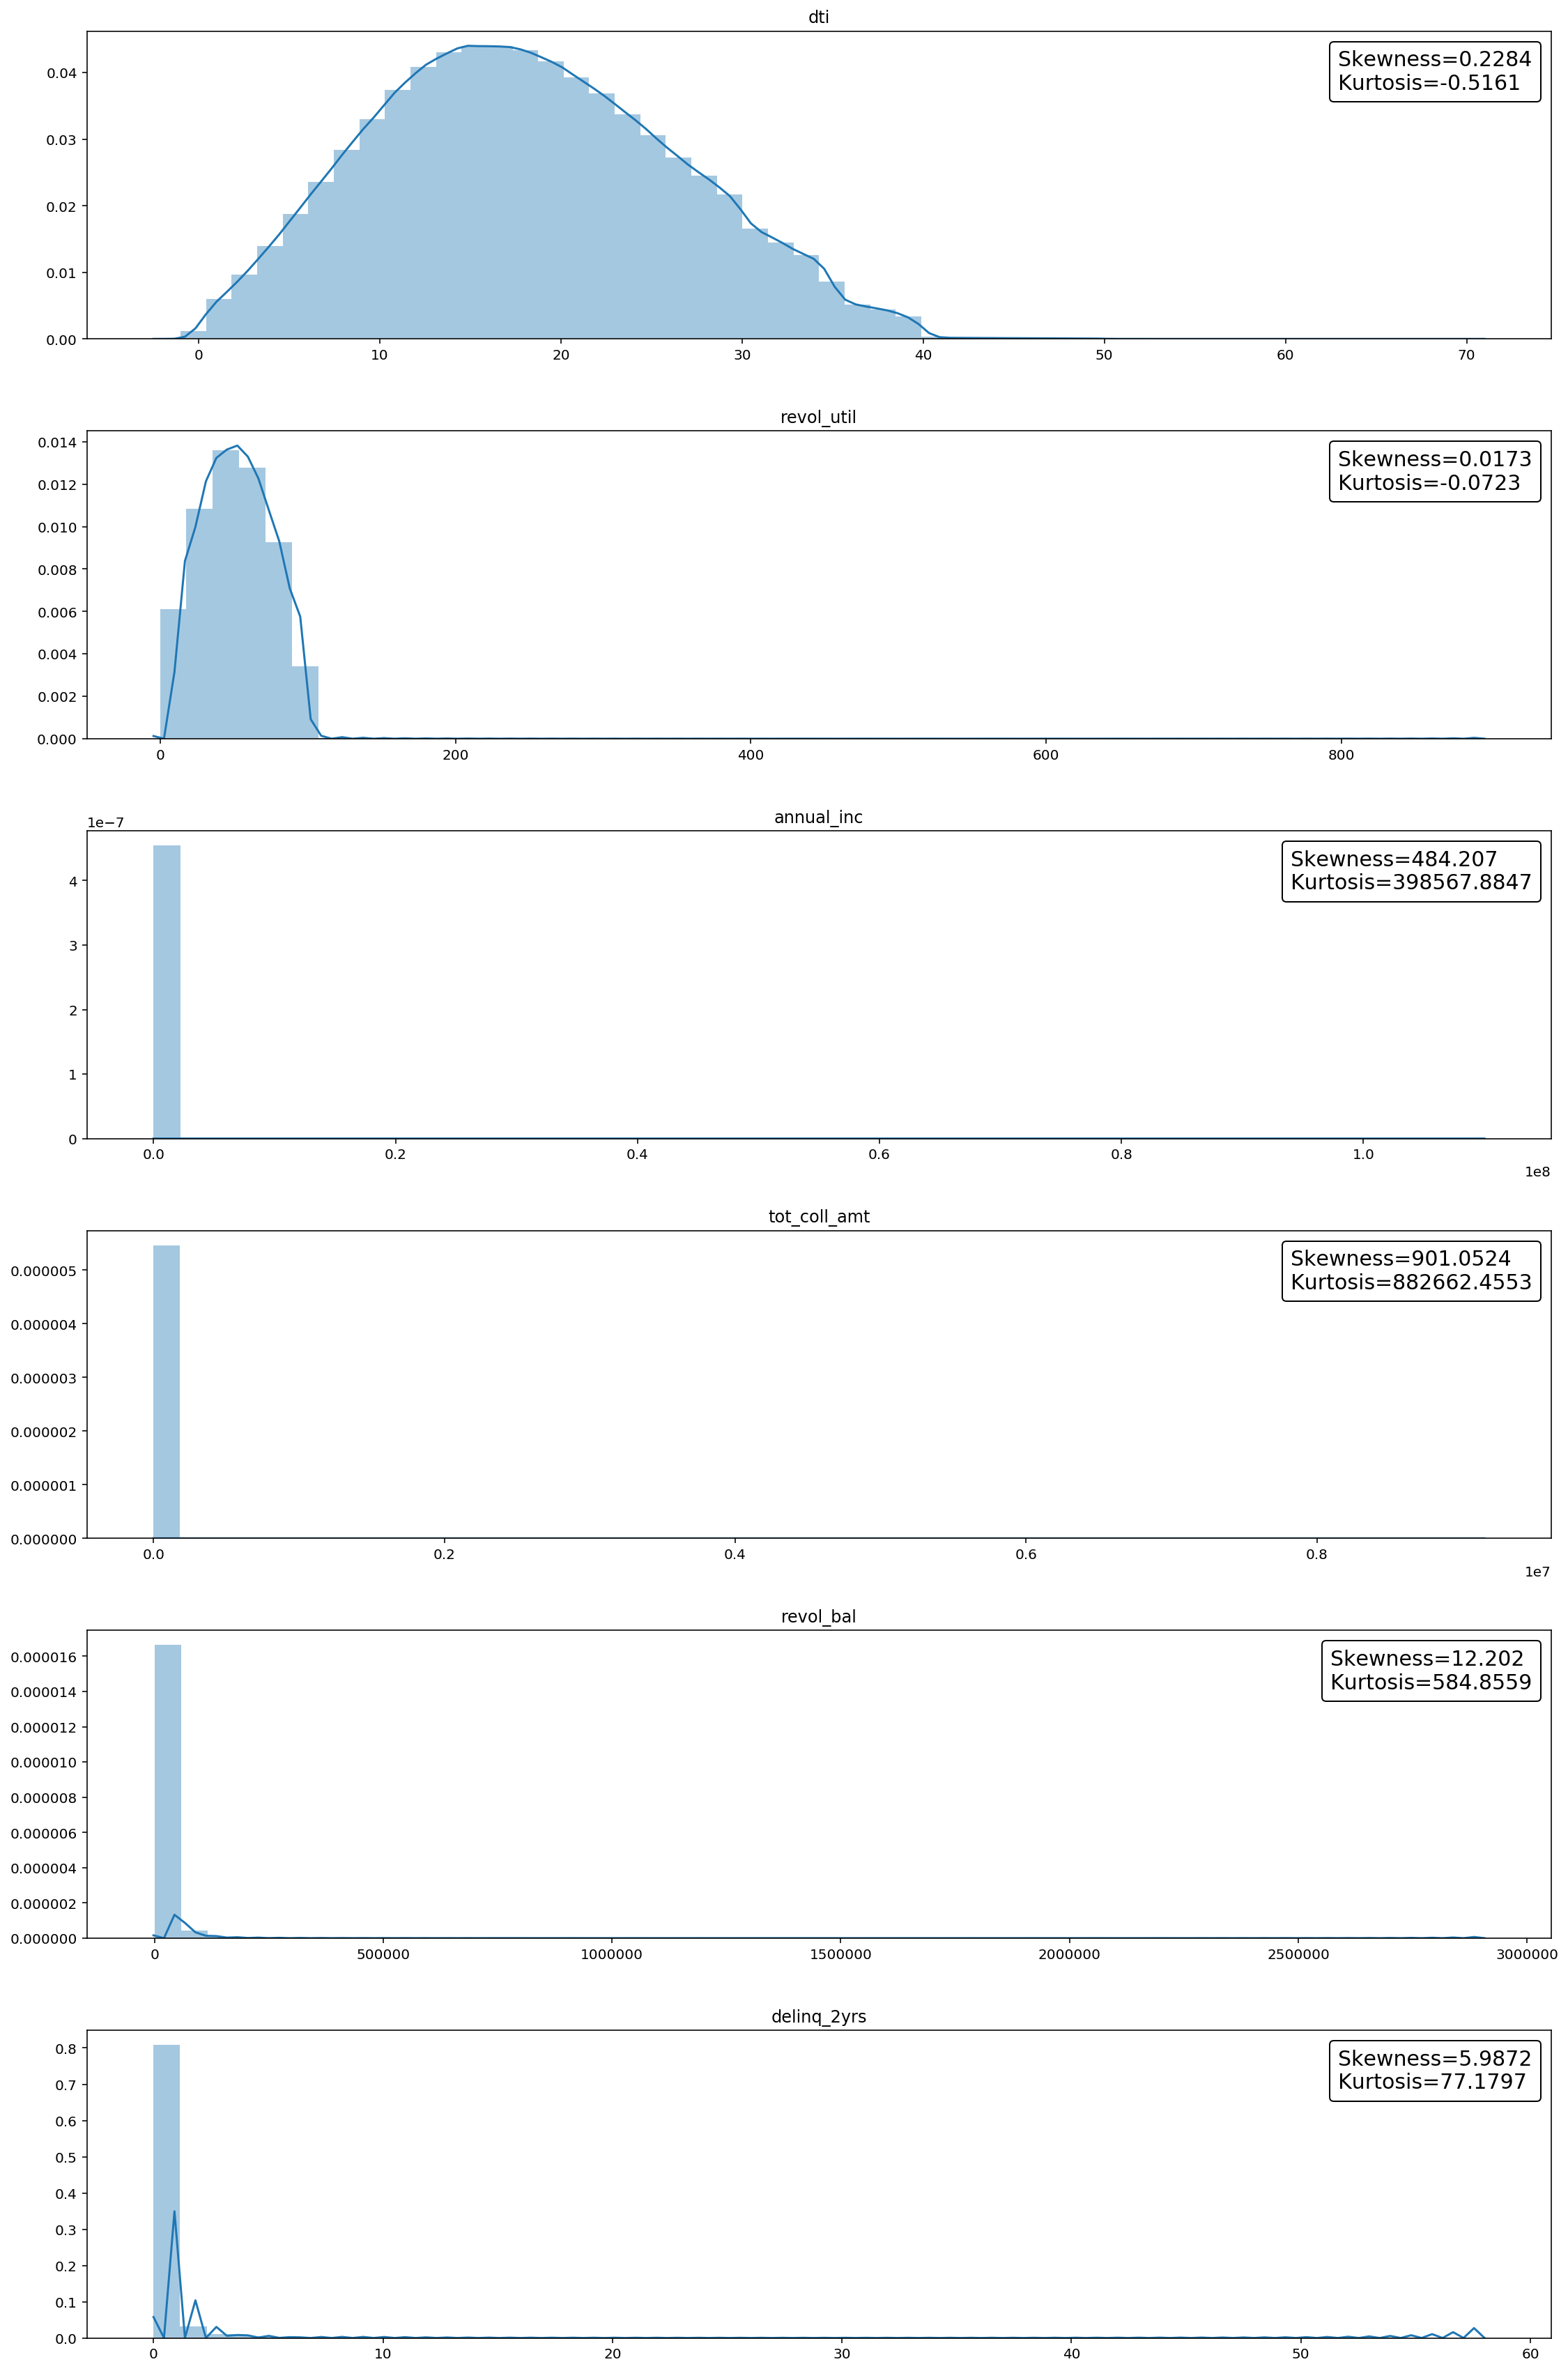

In [58]:
# Check distribution of Borrowers dti ratio (borrower’s total monthly debt payments on the total debt obligations)
f, axes = plt.subplots(len(col_list2), 1, figsize=(16, 24)) 

for i in range(len(col_list2)):
    skewness = round(xtrain[col_list2[i]].skew(),4)
    sns.distplot(xtrain[[col_list2[i]]].dropna(), hist=True, kde=True, ax = axes[i]
                ) 
    axes[i].set_title(col_list2[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[col_list2[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[col_list2[i]].kurt(),4)),
                  prop=dict(size=15), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)
    
    
f.tight_layout(pad=2.0) 
plt.show()

To fill missing values in the numerical variables with mean or median based on each variable's distribution:
- Use median (skewed distribution):
    'annual_inc','tot_coll_amt','revol_bal',
- Use mean (close to normal distribution):
    "dti","revol_util"

In [59]:
cols_median = ['annual_inc','tot_coll_amt','revol_bal',]

In [60]:
# Fill missing values with median for the following columns
for i in cols_median :
    xtrain.loc[xtrain[i].isnull(), i] = xtrain[i].median()

In [61]:
# Fill missing values for the following variables with mean value 
for i in ["dti","revol_util"]:
    xtrain.loc[xtrain[i].isnull(), i ] = xtrain[i].mean()

In [62]:
# Simply fill missing values for following columns with mode since the number of missing values is a small amount

for i in ["earliest_cr_line", "inq_last_6mths",'open_acc','total_acc',"pub_rec",
          "collections_12_mths_ex_med","acc_now_delinq", 'delinq_2yrs',
         ]:
    xtrain.loc[xtrain[i].isnull(), i] =xtrain[i].mode()[0]

In [63]:
# Extract the year in which the borrower has credit line
xtrain['earliest_cr_line'] = xtrain['earliest_cr_line'].str.extract('(\d+)').astype(int)

In [64]:
xtrain.isnull().sum()[xtrain.isnull().sum()!= 0]

tot_cur_bal                    56468
open_acc_6m                   692960
open_act_il                   692959
open_il_12m                   692959
open_il_24m                   692959
mths_since_rcnt_il            727965
total_bal_il                  692959
il_util                       855086
open_rv_12m                   692959
open_rv_24m                   692959
max_bal_bc                    692959
all_util                      693117
total_rev_hi_lim               56468
inq_fi                        692959
total_cu_tl                   692960
inq_last_12m                  692960
acc_open_past_24mths           40220
avg_cur_bal                    56521
bc_open_to_buy                 60202
bc_util                        61088
chargeoff_within_12_mths         118
delinq_amnt                       24
mo_sin_old_il_acct            111507
mo_sin_old_rev_tl_op           56469
mo_sin_rcnt_rev_tl_op          56469
mo_sin_rcnt_tl                 56468
mort_acc                       40220
m

### Handling missing value for attributes by categories|


                
#### Financial Trades related (finance trades, open trades, revolving trade): <br>
open_acc_6m  <br>
open_act_il  <br>
open_rv_12m  <br>
open_rv_24m  <br>
total_cu_tl  <br>
acc_open_past_24mths  <br>
num_actv_rev_tl  <br>
num_rev_tl_bal_gt_0  <br>

#### Bankcard related:
num_bc_tl  <br>
bc_open_to_buy  <br>
num_actv_bc_tl <br>
num_bc_sats <br>

percent_bc_gt_75 <br>
bc_util <br>
total_bc_limit <br>

mths_since_recent_bc <br>

#### Installment related:

num_il_tl <br>
open_il_12m <br>
open_il_24m <br>

total_bal_il <br>
il_util <br>
total_il_high_credit_limit <br>

mths_since_rcnt_il <br>
mo_sin_old_il_acct <br>

#### Revolving account
num_rev_accts <br>
num_op_rev_tl <br>
max_bal_bc   <br>
total_rev_hi_lim <br>


mo_sin_old_rev_tl_op  <br>          
mo_sin_rcnt_rev_tl_op <br>

#### General Account Info : 

num_tl_op_past_12m <br>
num_sats <br>
mort_acc <br>

tot_cur_bal <br>
avg_cur_bal <br>
tot_hi_cred_lim <br>
total_bal_ex_mort <br>

mo_sin_rcnt_tl <br>

#### Delinquency/past due/charge-off:

inq_fi <br>
inq_last_12m <br>
mths_since_recent_inq<br>
chargeoff_within_12_mths <br>
delinq_amnt <br>
num_tl_120dpd_2m     <br>          
num_tl_30dpd    <br>              
num_tl_90g_dpd_24m <br>
pub_rec_bankruptcies <br>
tax_lien<br>
num_accts_ever_120_pd <br>

#### Financial trades related

In [65]:
fin_trade_ind =[ "open_acc_6m"  ,
                    "open_act_il"  ,
                    "open_rv_12m" ,
                    "open_rv_24m"  ,
                    "total_cu_tl"  ,
                    "acc_open_past_24mths" , 
                    "num_actv_rev_tl"  ,
                    "num_rev_tl_bal_gt_0" ] 

'acc_open_past_24mths' measures the number of trades opened in past 24 months.
For rows that are missing value in'acc_open_past_24mths', all the financial trade related columns are NaN

In [66]:
xtrain.loc[xtrain.acc_open_past_24mths.isnull(),fin_trade_ind].sum()

open_acc_6m             0.0
open_act_il             0.0
open_rv_12m             0.0
open_rv_24m             0.0
total_cu_tl             0.0
acc_open_past_24mths    0.0
num_actv_rev_tl         0.0
num_rev_tl_bal_gt_0     0.0
dtype: float64

In [67]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtrain.loc[xtrain['acc_open_past_24mths'].isnull(),fin_trade_ind ] =0

In [68]:
fin_trade_ind.remove('acc_open_past_24mths')

In [69]:
xtrain.loc[xtrain.num_actv_rev_tl.isnull(),fin_trade_ind].sum()

open_acc_6m            0.0
open_act_il            0.0
open_rv_12m            0.0
open_rv_24m            0.0
total_cu_tl            0.0
num_actv_rev_tl        0.0
num_rev_tl_bal_gt_0    0.0
dtype: float64

In [70]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtrain.loc[xtrain['num_actv_rev_tl'].isnull(),fin_trade_ind ] =0

In [71]:
xtrain[fin_trade_ind].isnull().sum()

open_acc_6m            636492
open_act_il            636491
open_rv_12m            636491
open_rv_24m            636491
total_cu_tl            636492
num_actv_rev_tl             0
num_rev_tl_bal_gt_0         0
dtype: int64

In [72]:
for i in xtrain[fin_trade_ind].isnull().sum()[xtrain[fin_trade_ind].isnull().sum() == 0].index.tolist():
    fin_trade_ind.remove(i)

In [73]:
# Random sampling with replacement:
for i in fin_trade_ind:
    isnull = xtrain[i].isnull()
    random_sample = xtrain[i].dropna().sample(isnull.sum(), replace= True).values
    xtrain.loc[isnull,i] = random_sample

In [74]:
# Create a new column indicating this group of borrowers, who are likely not involved in trades
xtrain['is_null_total_cu_tl'] = xtrain.total_cu_tl.isnull().astype(int)

In [75]:
# Since these borrowers' are not involved in the open trades, I assign 0 to following variables.
for i in fin_trade_ind:
    xtrain.loc[xtrain[i].isnull(), i] = 0

#### Missing values at multiple features for the same instances
Noted that the following variables has the same amount of missing values(56468 +- 1) and confirmed that the missing values in these variables happen for the same instances. Looking at these variables as a group, my assumption is missing values in these variables indicate that the borrowers has no borrowings before (first-time borrowers)

In [76]:
xtrain.isnull().sum()[(xtrain.isnull().sum()== 56468)|(xtrain.isnull().sum()== 56469)]

tot_cur_bal                   56468
total_rev_hi_lim              56468
mo_sin_old_rev_tl_op          56469
mo_sin_rcnt_rev_tl_op         56469
mo_sin_rcnt_tl                56468
num_accts_ever_120_pd         56468
num_actv_bc_tl                56468
num_bc_tl                     56468
num_il_tl                     56468
num_op_rev_tl                 56468
num_rev_accts                 56469
num_tl_30dpd                  56468
num_tl_90g_dpd_24m            56468
num_tl_op_past_12m            56468
tot_hi_cred_lim               56468
total_il_high_credit_limit    56468
dtype: int64

In [77]:
print("percentage of missing values: %.4f "%(xtrain.tot_cur_bal.isnull().sum()/len(xtrain)))

percentage of missing values: 0.0312 


In [78]:
# compare the proportion of bad loans between the missing-value group and with-value group 
print(xtrain.loc[xtrain.tot_cur_bal.isnull(), "target"].mean())
print(xtrain.loc[xtrain.tot_cur_bal.notnull(), "target"].mean())

0.1582843380321598
0.13352921636513693


In [79]:
# obtain variable names for the missing values above
new_app_ind = xtrain.isnull().sum()[(xtrain.isnull().sum()== 56468)|(xtrain.isnull().sum()== 56469)].index.values

In [80]:
# Confirm that the missing for the following columns happen to the same instances
xtrain.loc[xtrain.tot_cur_bal.isnull(),new_app_ind].isnull().sum()

tot_cur_bal                   56468
total_rev_hi_lim              56468
mo_sin_old_rev_tl_op          56468
mo_sin_rcnt_rev_tl_op         56468
mo_sin_rcnt_tl                56468
num_accts_ever_120_pd         56468
num_actv_bc_tl                56468
num_bc_tl                     56468
num_il_tl                     56468
num_op_rev_tl                 56468
num_rev_accts                 56468
num_tl_30dpd                  56468
num_tl_90g_dpd_24m            56468
num_tl_op_past_12m            56468
tot_hi_cred_lim               56468
total_il_high_credit_limit    56468
dtype: int64

Assumption I made her is that for instances that have NaN values in the following variables are very likely new applicants has no any prior activities in the following variables. 

In [81]:
# Create a new column indicating this group of borrowers, who are likely to be new applicants.
xtrain['is_null_tot_cur_bal'] = xtrain.tot_cur_bal.isnull().astype(int)

In [82]:
# Assign 0 value fill missing values
newapp_cols = ['tot_cur_bal' ,                 
                'total_rev_hi_lim' ,              
                'num_accts_ever_120_pd',         
                'num_actv_bc_tl' ,               
                'num_actv_rev_tl',               
                'num_bc_tl' ,                   
                'num_il_tl' ,                    
                'num_op_rev_tl',                 
                'num_rev_accts'  ,               
                'num_rev_tl_bal_gt_0' ,         
                'num_tl_30dpd'   ,               
                'num_tl_90g_dpd_24m' ,           
                'num_tl_op_past_12m'  ,          
                'tot_hi_cred_lim',               
                'total_il_high_credit_limit' ] 
for i in newapp_cols:
    xtrain.loc[xtrain[i].isnull(), i] = 0

The following variables are related to how long since most recent or oldest accounts open.
Based on pattern above, these instances are very likely new borrowers, I decided to assigned the oldest date to them, indicating that they haven't been open new accounts for a while.

In [83]:
newapp_cols2= ["mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl"]
for i in newapp_cols2:
    xtrain.loc[xtrain[i].isnull(), i] = xtrain[i].max()
           

In [84]:
# check missing values again
xtrain.isnull().sum()[xtrain.isnull().sum()!= 0]

open_il_12m                 692959
open_il_24m                 692959
mths_since_rcnt_il          727965
total_bal_il                692959
il_util                     855086
max_bal_bc                  692959
all_util                    693117
inq_fi                      692959
inq_last_12m                692960
avg_cur_bal                  56521
bc_open_to_buy               60202
bc_util                      61088
chargeoff_within_12_mths       118
delinq_amnt                     24
mo_sin_old_il_acct          111507
mort_acc                     40220
mths_since_recent_bc         58944
mths_since_recent_inq       236524
num_bc_sats                  47042
num_sats                     47042
num_tl_120dpd_2m            123131
pct_tl_nvr_dlq               56592
percent_bc_gt_75             60545
pub_rec_bankruptcies          1070
tax_liens                       83
total_bal_ex_mort            40220
total_bc_limit               40220
dtype: int64

Continue filling missing values

In [85]:
# If number of installment account is 0, assign the oldest date to both 'mths_since_rcnt_il' and 'mo_sin_old_il_acct'
il_list = ['mths_since_rcnt_il','mo_sin_old_il_acct']
for i in il_list:
    xtrain.loc[xtrain.num_il_tl == 0 ,i]=xtrain[i].max()

In [86]:
# Random sample with replacement to fill the remaining missing values
for i in il_list:
    isnull = xtrain[i].isnull()
    random_sample = xtrain[i].dropna().sample(isnull.sum(), replace= True).values
    xtrain.loc[isnull,i] = random_sample
    

In [87]:
# Utilization related features
utli_list = ['il_util' ,                    
            'all_util',                    
            'bc_util' ]                 

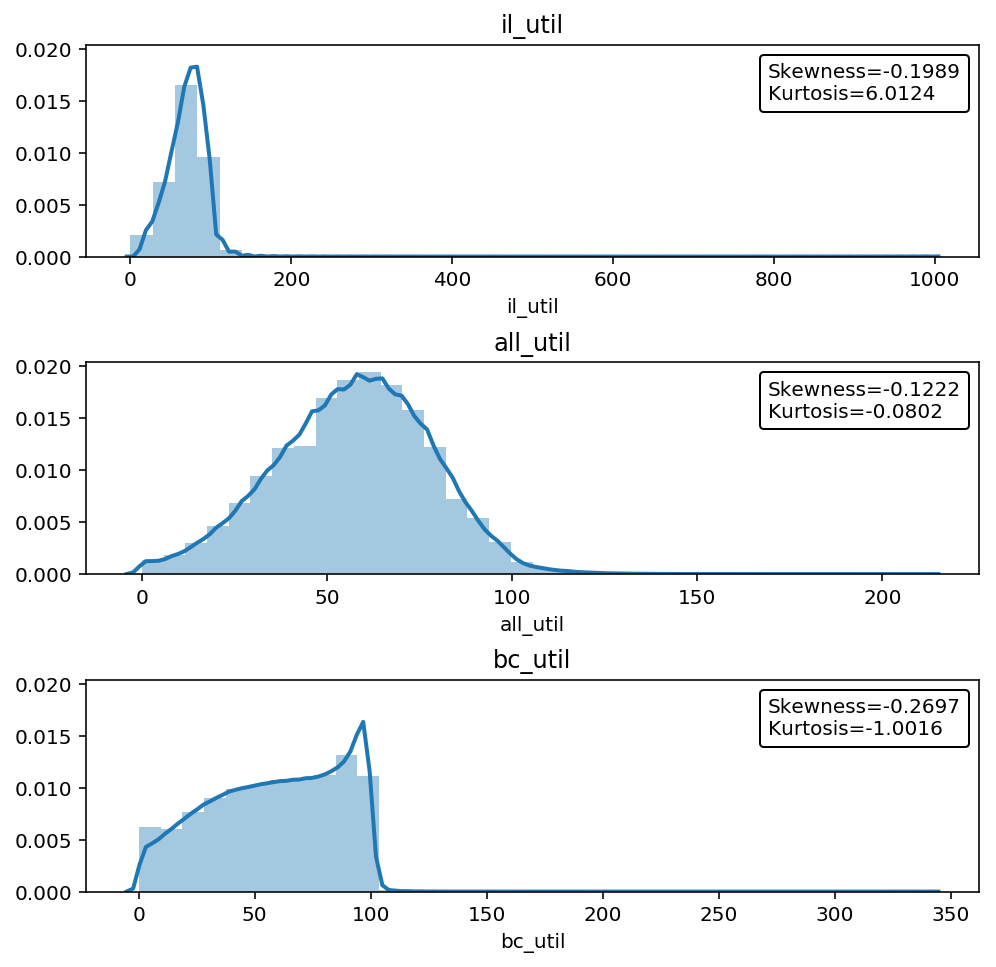

In [88]:
# Check distribution 
f, axes = plt.subplots(3, 1, figsize=(8, 6),  sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(3):
    
    # Histogram 1 - debt-to-income ratio
    sns.distplot(xtrain[utli_list[i]], hist=True, kde=True, 
                 bins=int(180/5), 
                 kde_kws={'linewidth': 2},ax = axes[i])
    axes[i].set_title(utli_list[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[utli_list[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[utli_list[i]].kurt(),4)),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)

plt.show()


In [89]:
# Balances-related features
bal_list = ['total_rev_hi_lim','avg_cur_bal',"tot_hi_cred_lim"]

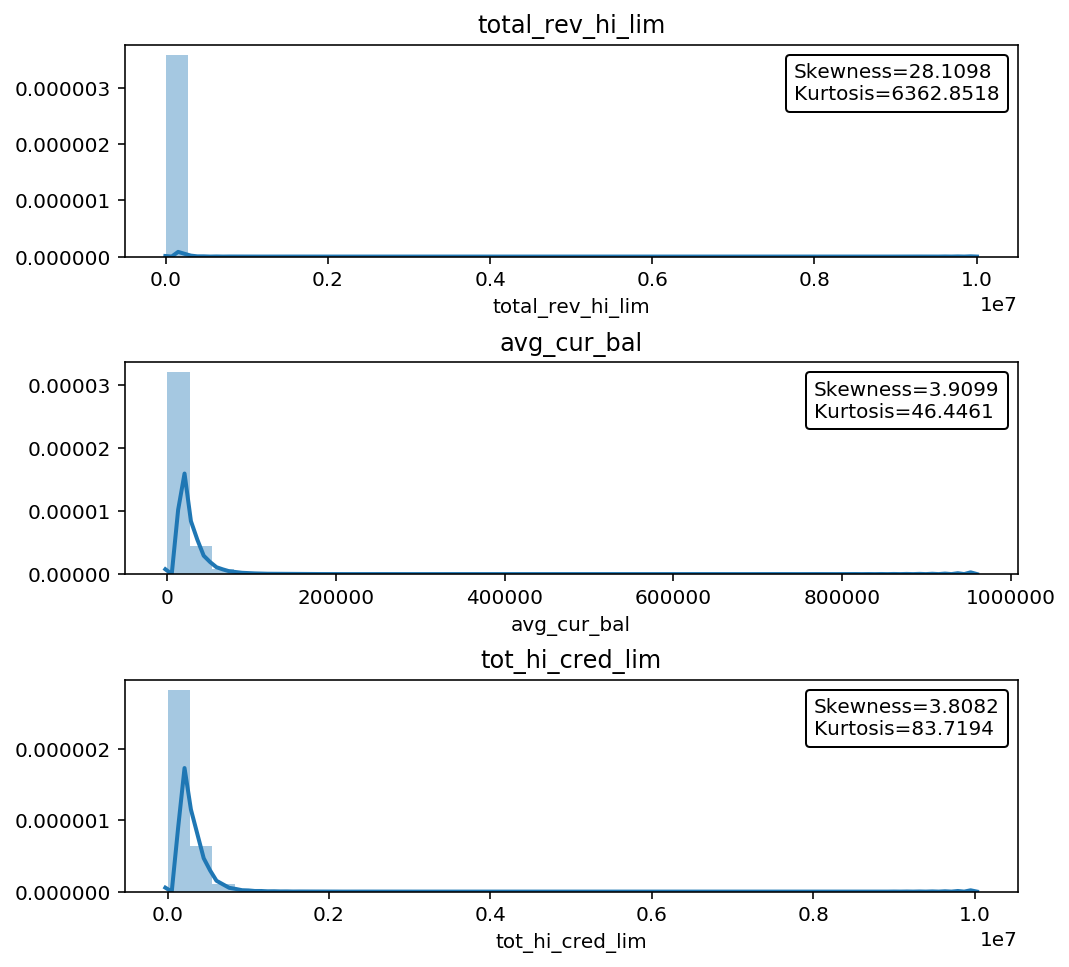

In [90]:
# Check distribution 
f, axes = plt.subplots(3, 1,  figsize=(8, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(3):
    
    sns.distplot(xtrain[bal_list[i]].dropna(), hist=True, kde=True, 
                 bins=int(180/5), 
                 kde_kws={'linewidth': 2},ax = axes[i])
    axes[i].set_title(bal_list[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[bal_list[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[bal_list[i]].kurt(),4)),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)
    

plt.show()


Skewness: -2.277774
Kurtosis: 6.829465


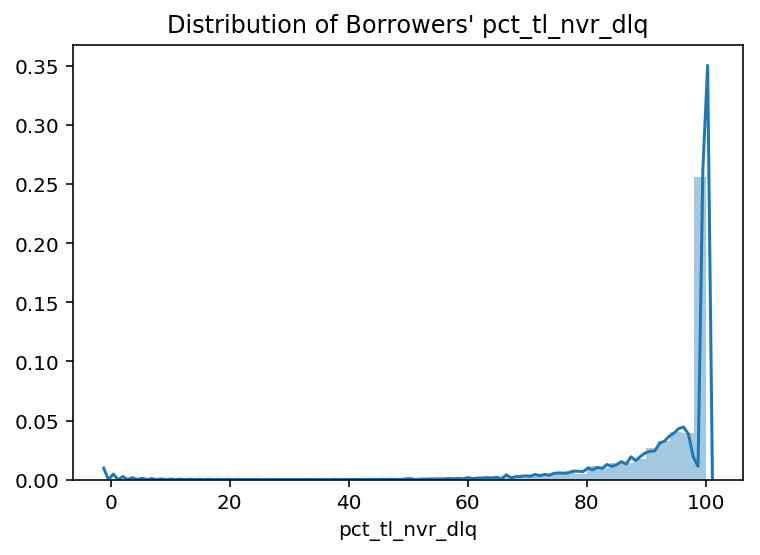

In [91]:
# Check distribution of Borrowers' percentage of trades nerve delinquent. 
#Left skewed distribution, use median to fill missing values
sns.distplot(xtrain["pct_tl_nvr_dlq"].dropna(), hist=True, kde=True,) 
             
plt.title("Distribution of Borrowers' pct_tl_nvr_dlq")
plt.xlabel("pct_tl_nvr_dlq")

print("Skewness: %f" % xtrain["pct_tl_nvr_dlq"].skew())
print("Kurtosis: %f" % xtrain["pct_tl_nvr_dlq"].kurt())


In [92]:
# The following features are all currency-related.
# As the distributions of following features are skewed, I assigned median to fill NaN

curr_var = ["avg_cur_bal",'il_util',"bc_open_to_buy",
            "pct_tl_nvr_dlq","total_bc_limit",'total_bal_ex_mort' ]
for i in curr_var:
    xtrain.loc[xtrain[i].isnull(), i]=xtrain[i].median()

In [93]:
# The distribution of utilization rate features is not skewed, use mean for missing values
util_cols = ["bc_util", 'all_util']
for i in util_cols:
    xtrain.loc[xtrain[i].isnull(), i]=xtrain[i].mean()

In [94]:
# These features are related to how many different accounts open/active, or how many months since last opened. I fill NaN with mode to match the population
acc_cols = ["mo_sin_old_il_acct", 'mths_since_recent_bc',              
             "mort_acc", "num_bc_sats","num_sats"]
      
for i in acc_cols:
    xtrain.loc[xtrain[i].isnull(), i] =xtrain[i].mode()[0]


Skewness: 0.309042
Kurtosis: -1.256349


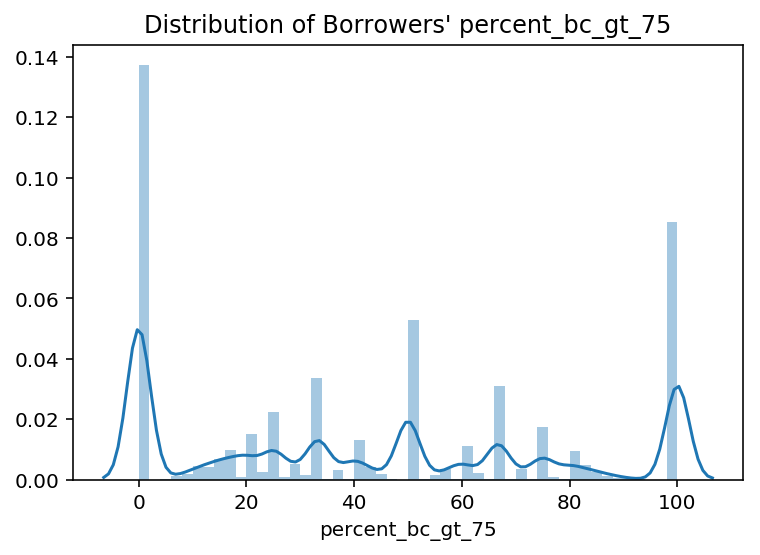

In [95]:
# Check distribution of Borrowers' percentage of all bankcard accounts > 75% of limit.
#Random sampling to fill missing values
sns.distplot(xtrain["percent_bc_gt_75"].dropna(), hist=True, kde=True,) 
             
plt.title("Distribution of Borrowers' percent_bc_gt_75")
plt.xlabel("percent_bc_gt_75")

print("Skewness: %f" % xtrain["percent_bc_gt_75"].skew())
print("Kurtosis: %f" % xtrain["percent_bc_gt_75"].kurt())


In [96]:
# Use random sampling to fill NaN for percent_bc_gt_75
percent_bc_gt_75_isnull = xtrain['percent_bc_gt_75'].isnull()
percent_bc_gt_75_random_sample = xtrain['percent_bc_gt_75'].dropna().sample(percent_bc_gt_75_isnull.sum(), replace= True).values
xtrain.loc[percent_bc_gt_75_isnull,'percent_bc_gt_75'] = percent_bc_gt_75_random_sample
    

In [97]:
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

open_il_12m                 692959
open_il_24m                 692959
total_bal_il                692959
max_bal_bc                  692959
inq_fi                      692959
inq_last_12m                692960
chargeoff_within_12_mths       118
delinq_amnt                     24
mths_since_recent_inq       236524
num_tl_120dpd_2m            123131
pub_rec_bankruptcies          1070
tax_liens                       83
dtype: int64

#### Days past due and Charge-off
Borrowers' past behaviors measured by day past due and chargeoff are important attributes in predicting borrowers' future loan payment activity, I would like to investigate more if there is more time

In [98]:
# Since the majority of loans (> 90%) falls in the mode value, I am filling NaN with mode. 
pdp_cols = ["chargeoff_within_12_mths" ,"delinq_amnt", "mths_since_recent_inq",
            "num_tl_120dpd_2m","pub_rec_bankruptcies","tax_liens"]

pdict = dict()
pdict['variables'] = []
pdict['mode'] = []
pdict['% of pop'] =[]
    
for i in pdp_cols:
    ratio = round(sum(xtrain[i] == xtrain[i].mode()[0])/len(xtrain),4)
    pdict['variables'].append(i)
    pdict['mode'].append(xtrain[i].mode()[0])
    pdict['% of pop'].append(ratio)

pd.DataFrame(pdict)   

,variables,mode,% of pop
0,chargeoff_within_12_mths,0.0,0.9923
1,delinq_amnt,0.0,0.9968
2,mths_since_recent_inq,1.0,0.0942
3,num_tl_120dpd_2m,0.0,0.9314
4,pub_rec_bankruptcies,0.0,0.8790
5,tax_liens,0.0,0.9714


In [99]:
pdp_cols.remove('mths_since_recent_inq')

In [100]:
pdp_cols

['chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'pub_rec_bankruptcies',
 'tax_liens']

In [101]:
# Filling NaN in dpd features with mode
for i in pdp_cols:
    xtrain.loc[xtrain[i].isnull(),i]= xtrain[i].mode()[0]

 Fill missing values at mths_since_recent_inq if the borrowers' finance inquiries and credit inquires are both zero, otherwise fill missing values with Random sampling with replacements.

In [102]:
xtrain.loc[(sum(xtrain.inq_fi + xtrain.inq_last_12m) ==0) & (xtrain.mths_since_recent_inq.isnull()), "mths_since_recent_inq"] = 0

In [103]:
mths_since_recent_inq_isnull = xtrain['mths_since_recent_inq'].isnull()
mths_since_recent_inq_random_sample = xtrain['mths_since_recent_inq'].dropna().sample(mths_since_recent_inq_isnull.sum(), replace= True).values
xtrain.loc[mths_since_recent_inq_isnull,'mths_since_recent_inq'] = mths_since_recent_inq_random_sample
  

In [104]:
# Check if any columns have missing values.
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

open_il_12m     692959
open_il_24m     692959
total_bal_il    692959
max_bal_bc      692959
inq_fi          692959
inq_last_12m    692960
dtype: int64

In [105]:
# The remaining columns have the exact same amount of missing values
# These columns are mostly related to installment account
installment_related = ["open_il_12m" , 
                    "open_il_24m",    
                    "total_bal_il",    
                    "max_bal_bc" ,     
                    "inq_fi",        
                    "inq_last_12m"]

for i in installment_related:
    xtrain.loc[xtrain[i].isnull(), i] = 0

In [106]:
# Check if any columns have missing values.
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

Series([], dtype: int64)

In [107]:
# remove id and url columns as they are not relevant to predicting default rate
for i in ["id", "url"]:
    xtrain.drop(i, axis=1, inplace=True)


### Feature engineering on Test set
Perform same feature engineering procedures on test set as the train set

In [108]:
# Convert issue date to year and month separate variables
xtest["issue_year"]= pd.to_datetime(xtest.issue_d).dt.year
xtest["issue_month"]= pd.to_datetime(xtest.issue_d).dt.month
xtest.drop("issue_d", axis=1,inplace = True)

In [109]:
# remove member_id column as it's just a system generated number
xtest.drop("member_id",axis=1, inplace= True)

In [110]:
# Create dummy variables for loans with desc and without
xtest["desc_y"]= np.where(xtest.desc.notnull(), 1, 0)
xtest["desc_n"]= np.where(xtest.desc.isnull(), 1, 0)
xtest.drop("desc", axis=1, inplace=True)

In [111]:
#Create dummy variables to indicate a loan with mths_since_last_record and without
xtest["pub_record_y"]= np.where(xtest.mths_since_last_record.notnull(), 1, 0)
xtest["pub_record_n"]= np.where(xtest.mths_since_last_record.isnull(), 1, 0)


In [112]:
# Obtain the combined values of joint borrowers for those joint loan applications
joint_ann_inc = xtest.loc[xtest.application_type=="Joint App","annual_inc_joint"].values
join_dti = xtest.loc[xtest.application_type=="Joint App","dti_joint"].values
joint_ver = xtest.loc[xtest.application_type=="Joint App","verification_status_joint"].values
joint_revo_bal = xtest.loc[xtest.application_type=="Joint App","revol_bal_joint"].values

# Combine joint variables into the their respective variables measuring individual borrowers
xtest.loc[xtest.application_type=="Joint App","annual_inc"]= joint_ann_inc
xtest.loc[xtest.application_type=="Joint App","dti"]= join_dti 
xtest.loc[xtest.application_type=="Joint App","verification_status"]= joint_ver
xtest.loc[xtest.application_type=="Joint App","revol_bal"]= joint_revo_bal

In [113]:
# Convert sec_app_fico_range_low from a numeric variable to a categorical variable
xtest["sec_app_fico_no"] = np.where(xtest.sec_app_fico_range_low.isnull(),1,0)
xtest["sec_app_fico_range_low_exceptional"] = np.where(xtest.sec_app_fico_range_low >= 800,1,0)
xtest["sec_app_fico_range_low_verygood"] = np.where((xtest.sec_app_fico_range_low >=740) & (xtest.sec_app_fico_range_low <= 799), 1,0)
xtest["sec_app_fico_range_low_good"] = np.where((xtest.sec_app_fico_range_low >=670) & (xtest.sec_app_fico_range_low <= 739), 1,0)
xtest["sec_app_fico_range_low_fair"] = np.where((xtest.sec_app_fico_range_low >=580) & (xtest.sec_app_fico_range_low <= 669), 1,0)
xtest["sec_app_fico_range_low_verypoor"] = np.where(xtest.sec_app_fico_range_low < 580,1,0)


In [114]:
#Convert sec_app_fico_range_high from a numeric variable to a categorical variable
xtest["sec_app_fico_range_high_exceptional"] = np.where(xtest.sec_app_fico_range_high >= 800,1,0)
xtest["sec_app_fico_range_high_verygood"] = np.where((xtest.sec_app_fico_range_high >=740) & (xtest.sec_app_fico_range_high <= 799), 1,0)
xtest["sec_app_fico_range_high_good"] = np.where((xtest.sec_app_fico_range_high >=670) & (xtest.sec_app_fico_range_high <= 739), 1,0)
xtest["sec_app_fico_range_high_fair"] = np.where((xtest.sec_app_fico_range_high >=580) & (xtest.sec_app_fico_range_high <= 669), 1,0)
xtest["sec_app_fico_range_high_verypoor"] = np.where(xtest.sec_app_fico_range_high < 580,1,0)


In [115]:
# Create dummies for loan's sec_app_inq_last_6mths
xtest["no_sec_app"] = np.where(xtest.sec_app_inq_last_6mths.isnull(),1,0)
sec_app_inq= pd.get_dummies(xtest.sec_app_inq_last_6mths, prefix="sec_app_inq_")
xtest = pd.concat([xtest, sec_app_inq], axis=1)


In [116]:
# Use Weighted Average method for delinquent related missing values

def fill_delinq(col):
    # Summary ratio of bad loans by variable of interest
    df = xtrain.loc[:,[col,"target"]].groupby([col]).agg(['mean', 'count'])
    
    # The ratio of bad loans in the missing value group
    target_mean = xtrain.loc[xtrain[col].isnull(),"target"].mean()
    target_std  = xtrain.loc[xtrain[col].isnull(),"target"].std()
    
    # Use the ratio of bad loans of the missing value group to find the existing data range that has similar bad loan ratio within +/-a range
    df= df.loc[(df['target']['mean'].values >= (target_mean - 0.05*target_std)) & (df['target']['mean'].values <= (target_mean + 0.05* target_std)),:]
    
    df["weighted_avg"] = df['target']['count']/sum(df['target']['count'])
    
    w_avg =0
    for i in range(len(df)):
        w_avg += df.index[i] * df.weighted_avg.tolist()[i]
       
    
    return w_avg
    

In [117]:
# Fill NaN for delinquence related features.
# Based on the point plot of delinquent-related features vs target, the ratio of bad loans decreases as the number of months since last/recent delinquent increases.

del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog"]

for col in del_cols:
    w_avg =fill_delinq(col)
    xtest.loc[xtest[col].isnull(), col ] = w_avg

In [118]:
# Now we are ready to drop the features with over 80% missing values
xtest.drop(["mths_since_last_record" ,
            "annual_inc_joint" ,                      
            "dti_joint",                              
            "verification_status_joint"  ,            
            "revol_bal_joint"   ,                     
            "sec_app_fico_range_low",                
            "sec_app_fico_range_high",             
            "sec_app_earliest_cr_line",        
            "sec_app_inq_last_6mths"  ,               
            "sec_app_mort_acc" ,                     
            "sec_app_open_acc"  ,                     
            "sec_app_revol_util"  ,                
            "sec_app_open_act_il" ,                  
            "sec_app_num_rev_accts" ,               
            "sec_app_chargeoff_within_12_mths" ,      
            "sec_app_collections_12_mths_ex_med" ,    
            "sec_app_mths_since_last_major_derog" ],
          axis=1, inplace=True)

In [119]:
# Double Check if any columns with more than 50% missing values
xtest.isnull().sum()[xtest.isnull().sum()/len(xtest)>=0.5]

Series([], dtype: int64)

#### Continue handling missing values


In [120]:
xtest.isnull().sum()[xtest.isnull().sum()!=0]

emp_title                     33443
emp_length                    29456
annual_inc                        1
verification_status            1019
title                          4634
                              ...  
tax_liens                        22
tot_hi_cred_lim               13808
total_bal_ex_mort              9810
total_bc_limit                 9810
total_il_high_credit_limit    13808
Length: 68, dtype: int64

Employment title

In [121]:
#Assign missing values in emp_title as undisclosed 
xtest.loc[xtest.emp_title.isnull(), "emp_title"] ="Undisclosed"

In [122]:
# The group similar employment title together, and create dummy variables for the top 5 employee title categories, and the rest would be Other
mgt_title =['Manager','manager','Supervisor','supervisor','President','president',
            'Director','Leader','director','leader','Administrator','administrator','VP']
nurse_title = ['Registered Nurse','nurse','Nurse','RN']
teacher_title = ['teacher','Teacher']
owner_title = ['Owner','owner']
driver_title = ['Driver','driver']
titles = dict({"mgt_title":mgt_title,"nurse_title":nurse_title,"teacher_title": teacher_title,
               "owner_title": owner_title,"driver_title":driver_title})


In [123]:
# Create a dictionary for these employment title variables
title_dict = {}
for key,value in titles.items():
    title_dict[key]=[int(sum([1 if j in value else 0 for j in i.split()]) > 0) for i in xtest['emp_title'].values ]
    


In [124]:
# Concat the employee title dummy variables 
title_df = pd.DataFrame(title_dict)
title_df.reset_index(drop=True, inplace=True)
xtest.reset_index(drop=True, inplace=True)
xtest = pd.concat([xtest, title_df], axis=1)

In [125]:
# Add dummy variable of employment title to the dataset
xtest['emp_undisc'] = np.where(xtest.emp_title=='Undisclosed',1,0)

In [126]:
# Add dummy variable of Other employment title to the dataset
xtest['title_other'] = np.where((xtest.emp_undisc + xtest.mgt_title + xtest.nurse_title + 
                                 xtest.teacher_title + xtest.owner_title+ xtest.driver_title) == 0,1,0)

In [127]:
xtest.drop("emp_title", axis=1, inplace=True)

Employment length

In [128]:
# As the majority of missing values in emp_length are associated with undisclosed emp_title. I will fill NA values in emp_length with random samples from the undisclosed group
emp_len_isnull = xtest.emp_length.isnull()
emp_len_samples = xtest.loc[(xtest.emp_undisc==1) & (xtest.emp_length.notnull()), 'emp_length'].sample(emp_len_isnull.sum(),replace= True).values
xtest.loc[emp_len_isnull,"emp_length"] = emp_len_samples

In [129]:
# Extract the number of years from emp_length column, convert it to string and fill NaN with the mean.
xtest['emp_length'] = xtest['emp_length'].str.extract('(\d+)')
xtest['emp_length'] = pd.to_numeric(xtest["emp_length"])
# Assumptions: borrowers who has 10 years or more than 10 years of employment are similar in their debt repaymnet 

Loan grade and subgrade

In [130]:
# Assgin a score to each loan grade by calculating the ratio of bad loans in each grade
dfgrade = xtest.loc[:,["grade","target"]].groupby(["grade"]).mean()
dfgrade = round(dfgrade*100,0).to_dict()['target']
dfgrade

{'A': 4.0, 'B': 9.0, 'C': 15.0, 'D': 21.0, 'E': 29.0, 'F': 37.0, 'G': 40.0}

In [131]:
# Assgin a score to each loan subgrade by calculating the ratio of bad loans in each grade
dfsubgrade = xtest.loc[:,["sub_grade","target"]].groupby(["sub_grade"]).mean()
dfsubgrade = round(dfsubgrade*100,0).to_dict()['target']

In [132]:
# Convert loan grade and loan subgrades to numerica value
xtest['grade'] = xtest['grade'].map(dfgrade)
xtest['sub_grade'] = xtest['sub_grade'].map(dfsubgrade)

Loan purpose

In [133]:
# Drop xolumn title as it provides similar information of loan purpose. 
xtest.drop("title",axis=1, inplace=True)

In [134]:
# check missing values for the following columns before converting them to dummy variables
xtest[["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
        ]].isnull().sum()

application_type          0
initial_list_status       0
term                      0
purpose                   0
home_ownership            0
verification_status    1019
disbursement_method       0
dtype: int64

In [135]:
xtest.loc[xtest.verification_status.isnull(),"verification_status"]='verified_unknown'

In [136]:
todummy = ["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
          ]
    
# Convert application_type to dummy variables
for i in todummy:
    dummy = pd.get_dummies(xtest[i], prefix = i)
    xtest = pd.concat([xtest, dummy], axis=1)
    xtest.drop(i, axis=1, inplace=True)


In [137]:
# combine home ownership other, none and any into one group:Other
xtest.home_ownership_OTHER = xtest.home_ownership_OTHER + xtest.home_ownership_ANY + \
    xtest.home_ownership_NONE
 
xtest.drop(["home_ownership_ANY","home_ownership_NONE"], axis=1, inplace=True)

Borrower's Address, state and zip code

In [138]:
address = ["addr_state","zip_code"]
# Calculate the percentage of bad loans of each state
for i in address:
    df= xtest.loc[:,[i,"target"]].groupby([i]).mean()
    df  = round(df*100,2).to_dict()['target']
    xtest[i] = xtest[i].map(df)

In [139]:
# Noted there is one missing value in zip_code, fillna with mode
xtest.loc[xtest.zip_code.isnull(), "zip_code"] = xtest['zip_code'].mode()[0]

In [140]:
col_list2 = ['dti', # borrower’s total monthly debt payments on the total debt obligations
    'revol_util', # Borrowers' revol_utilization rate
     'annual_inc', # annual income
    'tot_coll_amt', # Total collection amounts ever owed
    'revol_bal', # Total credit revolving balance
    'delinq_2yrs'#Number of 30+days past-due incidences of delinquency for the past 2 years
            ]

To fill missing values in the numerical variables with mean or median based on each variable's distribution:
- Use median (skewed distribution):
    'annual_inc','tot_coll_amt','revol_bal',
- Use mean (close to normal distribution):
    "dti","revol_util"

In [141]:
cols_median = ['annual_inc','tot_coll_amt','revol_bal',]

In [142]:
# Fill missing values with median for the following columns
for i in cols_median :
    xtest.loc[xtest[i].isnull(), i] = xtest[i].median()

In [143]:
# Fill missing values for the following variables with mean value 
for i in ["dti","revol_util"]:
    xtest.loc[xtest[i].isnull(), i ] = xtest[i].mean()

In [144]:
# Simply fill missing values for following columns with mode since the number of missing values is a small amount

for i in ["earliest_cr_line", "inq_last_6mths",'open_acc','total_acc',"pub_rec",
          "collections_12_mths_ex_med","acc_now_delinq", 'delinq_2yrs',
         ]:
    xtest.loc[xtest[i].isnull(), i] =xtest[i].mode()[0]

In [145]:
# Extract the year in which the borrower has credit line
xtest['earliest_cr_line'] = xtest['earliest_cr_line'].str.extract('(\d+)').astype(int)

### Handling missing value for attributes by categories|


                
#### Financial Trades related (finance trades, open trades, revolving trade): <br>
open_acc_6m  <br>
open_act_il  <br>
open_rv_12m  <br>
open_rv_24m  <br>
total_cu_tl  <br>
acc_open_past_24mths  <br>
num_actv_rev_tl  <br>
num_rev_tl_bal_gt_0  <br>

#### Bankcard related:
num_bc_tl  <br>
bc_open_to_buy  <br>
num_actv_bc_tl <br>
num_bc_sats <br>

percent_bc_gt_75 <br>
bc_util <br>
total_bc_limit <br>

mths_since_recent_bc <br>

#### Installment related:

num_il_tl <br>
open_il_12m <br>
open_il_24m <br>

total_bal_il <br>
il_util <br>
total_il_high_credit_limit <br>

mths_since_rcnt_il <br>
mo_sin_old_il_acct <br>

#### Revolving account
num_rev_accts <br>
num_op_rev_tl <br>
max_bal_bc   <br>
total_rev_hi_lim <br>


mo_sin_old_rev_tl_op  <br>          
mo_sin_rcnt_rev_tl_op <br>

#### General Account Info : 

num_tl_op_past_12m <br>
num_sats <br>
mort_acc <br>

tot_cur_bal <br>
avg_cur_bal <br>
tot_hi_cred_lim <br>
total_bal_ex_mort <br>

mo_sin_rcnt_tl <br>

#### Delinquency/past due/charge-off:

inq_fi <br>
inq_last_12m <br>
mths_since_recent_inq<br>
chargeoff_within_12_mths <br>
delinq_amnt <br>
num_tl_120dpd_2m     <br>          
num_tl_30dpd    <br>              
num_tl_90g_dpd_24m <br>
pub_rec_bankruptcies <br>
tax_lien<br>
num_accts_ever_120_pd <br>

#### Financial trades related

In [146]:
fin_trade_ind =[ "open_acc_6m"  ,
                    "open_act_il"  ,
                    "open_rv_12m" ,
                    "open_rv_24m"  ,
                    "total_cu_tl"  ,
                    "acc_open_past_24mths" , 
                    "num_actv_rev_tl"  ,
                    "num_rev_tl_bal_gt_0" ] 

'acc_open_past_24mths' measures the number of trades opened in past 24 months.
For rows that are missing value in'acc_open_past_24mths', all the financial trade related columns are NaN

In [147]:
xtest.loc[xtest.acc_open_past_24mths.isnull(),fin_trade_ind].sum()

open_acc_6m             0.0
open_act_il             0.0
open_rv_12m             0.0
open_rv_24m             0.0
total_cu_tl             0.0
acc_open_past_24mths    0.0
num_actv_rev_tl         0.0
num_rev_tl_bal_gt_0     0.0
dtype: float64

In [148]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtest.loc[xtest['acc_open_past_24mths'].isnull(),fin_trade_ind ] =0

In [149]:
fin_trade_ind.remove('acc_open_past_24mths')

In [150]:
xtest.loc[xtest.num_actv_rev_tl.isnull(),fin_trade_ind].sum()

open_acc_6m            0.0
open_act_il            0.0
open_rv_12m            0.0
open_rv_24m            0.0
total_cu_tl            0.0
num_actv_rev_tl        0.0
num_rev_tl_bal_gt_0    0.0
dtype: float64

In [151]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtest.loc[xtest['num_actv_rev_tl'].isnull(),fin_trade_ind ] =0

In [152]:
xtest[fin_trade_ind].isnull().sum()

open_acc_6m            159362
open_act_il            159362
open_rv_12m            159362
open_rv_24m            159362
total_cu_tl            159362
num_actv_rev_tl             0
num_rev_tl_bal_gt_0         0
dtype: int64

In [153]:
for i in xtest[fin_trade_ind].isnull().sum()[xtest[fin_trade_ind].isnull().sum() == 0].index.tolist():
    fin_trade_ind.remove(i)

In [154]:
# Random sampling with replacement:
for i in fin_trade_ind:
    isnull = xtest[i].isnull()
    random_sample = xtest[i].dropna().sample(isnull.sum(), replace= True).values
    xtest.loc[isnull,i] = random_sample

In [155]:
# Create a new column indicating this group of borrowers, who are likely not involved in trades
xtest['is_null_total_cu_tl'] = xtest.total_cu_tl.isnull().astype(int)

In [156]:
# Since these borrowers' are not involved in the open trades, I assign 0 to following variables.
for i in fin_trade_ind:
    xtest.loc[xtest[i].isnull(), i] = 0

In [157]:
# Create a new column indicating this group of borrowers, who are likely to be new applicants.
xtest['is_null_tot_cur_bal'] = xtrain.tot_cur_bal.isnull().astype(int)

In [158]:
# Assign 0 value fill missing values
newapp_cols = ['tot_cur_bal' ,                 
                'total_rev_hi_lim' ,              
                'num_accts_ever_120_pd',         
                'num_actv_bc_tl' ,               
                'num_actv_rev_tl',               
                'num_bc_tl' ,                   
                'num_il_tl' ,                    
                'num_op_rev_tl',                 
                'num_rev_accts'  ,               
                'num_rev_tl_bal_gt_0' ,         
                'num_tl_30dpd'   ,               
                'num_tl_90g_dpd_24m' ,           
                'num_tl_op_past_12m'  ,          
                'tot_hi_cred_lim',               
                'total_il_high_credit_limit' ] 
for i in newapp_cols:
    xtest.loc[xtest[i].isnull(), i] = 0

The following variables are related to how long since most recent or oldest accounts open.
Based on pattern above, these instances are very likely new borrowers, I decided to assigned the oldest date to them, indicating that they haven't been open new accounts for a while.

In [159]:
newapp_cols2= ["mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl"]
for i in newapp_cols2:
    xtest.loc[xtest[i].isnull(), i] = xtest[i].max()
           

Continue filling missing values

In [160]:
# If number of installment account is 0, assign the oldest date to both 'mths_since_rcnt_il' and 'mo_sin_old_il_acct'
il_list = ['mths_since_rcnt_il','mo_sin_old_il_acct']
for i in il_list:
    xtest.loc[xtest.num_il_tl == 0 ,i]=xtest[i].max()

In [161]:
# Random sample with replacement to fill the remaining missing values
for i in il_list:
    isnull = xtest[i].isnull()
    random_sample = xtest[i].dropna().sample(isnull.sum(), replace= True).values
    xtest.loc[isnull,i] = random_sample
    

In [162]:
# Utilization related features
utli_list = ['il_util' ,                    
            'all_util',                    
            'bc_util' ]                 

In [163]:
# Balances-related features
bal_list = ['total_rev_hi_lim','avg_cur_bal',"tot_hi_cred_lim"]

In [164]:
# The following features are all currency-related.
# As the distributions of following features are skewed, I assigned median to fill NaN

curr_var = ["avg_cur_bal",'il_util',"bc_open_to_buy",
            "pct_tl_nvr_dlq","total_bc_limit",'total_bal_ex_mort' ]
for i in curr_var:
    xtest.loc[xtest[i].isnull(), i]=xtrain[i].median()

In [165]:
# The distribution of utilization rate features is not skewed, use mean for missing values
util_cols = ["bc_util", 'all_util']
for i in util_cols:
    xtest.loc[xtest[i].isnull(), i]=xtrain[i].mean()

In [166]:
# These features are related to how many different accounts open/active, or how many months since last opened. I fill NaN with mode to match the population
acc_cols = ["mo_sin_old_il_acct", 'mths_since_recent_bc',              
             "mort_acc", "num_bc_sats","num_sats"]
      
for i in acc_cols:
    xtest.loc[xtest[i].isnull(), i] =xtrain[i].mode()[0]

In [167]:
# Use random sampling to fill NaN for percent_bc_gt_75
percent_bc_gt_75_isnull = xtest['percent_bc_gt_75'].isnull()
percent_bc_gt_75_random_sample = xtest['percent_bc_gt_75'].dropna().sample(percent_bc_gt_75_isnull.sum(), replace= True).values
xtest.loc[percent_bc_gt_75_isnull,'percent_bc_gt_75'] = percent_bc_gt_75_random_sample

#### Days past due and Charge-off
Borrowers' past behaviors measured by day past due and chargeoff are important attributes in predicting borrowers' future loan payment activity, I would like to investigate more if there is more time

In [168]:
# Since the majority of loans (> 90%) falls in the mode value, I am filling NaN with mode. 
pdp_cols = ["chargeoff_within_12_mths" ,"delinq_amnt", "mths_since_recent_inq",
            "num_tl_120dpd_2m","pub_rec_bankruptcies","tax_liens"]

pdp_cols.remove('mths_since_recent_inq')

In [169]:
# Filling NaN in dpd features with mode
for i in pdp_cols:
    xtest.loc[xtest[i].isnull(),i]= xtrain[i].mode()[0]

 Fill missing values at mths_since_recent_inq if the borrowers' finance inquiries and credit inquires are both zero, otherwise fill missing values with Random sampling with replacements.

In [170]:
xtest.loc[(sum(xtest.inq_fi + xtest.inq_last_12m) ==0) & (xtest.mths_since_recent_inq.isnull()), "mths_since_recent_inq"] = 0

In [171]:
mths_since_recent_inq_isnull = xtest['mths_since_recent_inq'].isnull()
mths_since_recent_inq_random_sample = xtest['mths_since_recent_inq'].dropna().sample(mths_since_recent_inq_isnull.sum(), replace= True).values
xtest.loc[mths_since_recent_inq_isnull,'mths_since_recent_inq'] = mths_since_recent_inq_random_sample
  

In [172]:
# Check if any columns have missing values. Now all columns have no NaN values
xtest.isnull().sum()[xtest.isnull().sum()!=0]

open_il_12m     173170
open_il_24m     173170
total_bal_il    173170
max_bal_bc      173170
inq_fi          173170
inq_last_12m    173170
dtype: int64

In [173]:
# The remaining columns have the exact same amount of missing values
# These columns are mostly related to installment account
installment_related = ["open_il_12m" , 
                    "open_il_24m",    
                    "total_bal_il",    
                    "max_bal_bc" ,     
                    "inq_fi",        
                    "inq_last_12m"]

for i in installment_related:
    xtest.loc[xtest[i].isnull(), i] = 0

In [174]:
# Check if any columns have missing values. Now all columns have no NaN values
xtest.isnull().sum()[xtest.isnull().sum()!=0]

Series([], dtype: int64)

In [175]:
# remove id and url columns as they are not relevant to predicting default rate
for i in ["id", "url"]:
    xtest.drop(i, axis=1, inplace=True)

In [176]:
# generate target variable vector: ytrain and ytest
ytrain = xtrain['target']
ytest = xtest['target']

In [179]:
# drop target variable from the X matrix
xtrain.drop("loan_status", axis=1, inplace=True)
xtrain.drop("target", axis=1, inplace=True)

xtest.drop("loan_status", axis=1, inplace=True)
xtest.drop("target", axis=1, inplace=True)

In [180]:
all_cols = xtrain.columns.tolist()
num_cols = xtrain._get_numeric_data().columns.tolist()
cat_cols = list(set(all_cols) - set(num_cols))

In [181]:
all_cols_test = xtest.columns.tolist()
num_cols_test = xtest._get_numeric_data().columns.tolist()
cat_cols_test = list(set(all_cols) - set(num_cols))


In [182]:
# Make sure all the columns in xtest are the same as xtrain
len(all_cols) == len(all_cols_test)

True

In [183]:
# Save cleaned training and test dataset
xtrain.to_csv("xtrain_cleaned.csv")
ytrain.to_csv("ytrain.csv")
xtest.to_csv("xtest_cleaned.csv")
ytest.to_csv("ytest.csv")